In [1]:
import pandas as pd
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
npx.set_np()

In [2]:
train_data = pd.read_csv('D://DS//Stater_Projects//house//train.csv')
test_data = pd.read_csv('D://DS//Stater_Projects//house//test.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [5]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [8]:
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [9]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [10]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [11]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype=np.float32)
test_features = np.array(all_features[n_train:].values, dtype=np.float32)
train_labels = np.array(train_data.SalePrice.values.reshape(-1, 1),dtype=np.float32)

In [12]:
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [15]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

In [16]:
def train(net, train_features, train_labels, test_features, test_labels,num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate,'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [17]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate([X_train, X_part], 0)
            y_train = np.concatenate([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [18]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, 'f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 4.580824, valid log rmse 4.565061
fold 2, train log rmse 4.574836, valid log rmse 4.614132
fold 3, train log rmse 4.577705, valid log rmse 4.583677
fold 4, train log rmse 4.577786, valid log rmse 4.589447
fold 5, train log rmse 4.577485, valid log rmse 4.589143
fold 6, train log rmse 4.577082, valid log rmse 4.593821
fold 7, train log rmse 4.581830, valid log rmse 4.554708
fold 8, train log rmse 4.581625, valid log rmse 4.559632
fold 9, train log rmse 4.575475, valid log rmse 4.606088
fold 10, train log rmse 4.581698, valid log rmse 4.555153
10-fold validation: avg train log rmse: 4.578635, avg valid log rmse: 4.581086


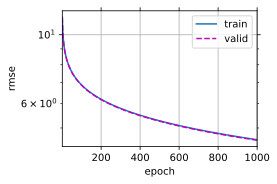

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 10, 1000, 0.001, 0, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, 'f'avg valid log rmse: {float(valid_l):f}')

In [21]:
def train_and_pred(train_features, test_feature, train_labels, test_data,num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 4.479098


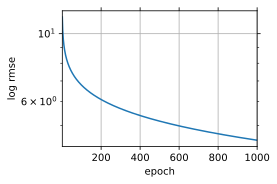

In [22]:
train_and_pred(train_features, test_features, train_labels, test_data,num_epochs, lr, weight_decay, batch_size)